# GARCH Model in Finace Prediction
Generalized AutoRegressive Conditional Heteroskedasticity

* Autoregressive: predict future behavior based on past behavior
    
* Volatility as a weighted average of past information

## Visualize volatility clustering

In [66]:
import warnings
warnings.simplefilter('ignore')
from arch import arch_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('darkgrid')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

The sp500 data comes from Yahoo! Finance which can be loaded from arch.data.sp500

In [71]:
import datetime as dt
import arch.data.sp500
data = arch.data.sp500.load()
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [72]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613930000
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4233990000
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000
2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000


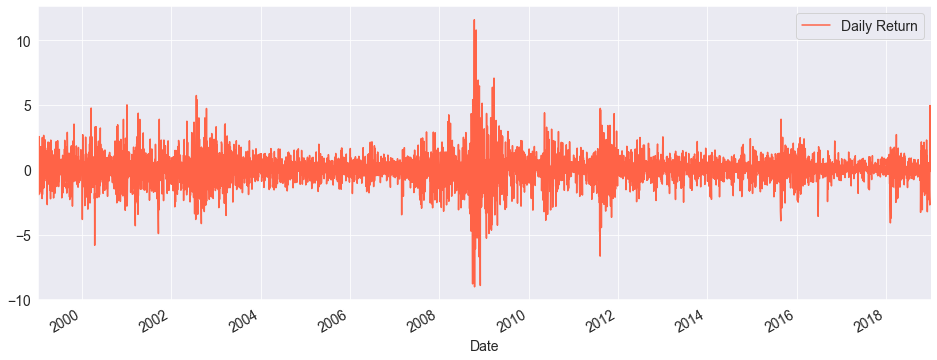

In [73]:
market = data['Adj Close']
returns = 100 * market.pct_change().dropna()
ax = returns.plot(color = 'tomato', label = 'Daily Return')
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
plt.legend(loc='upper right')
plt.show()


## Compute volatility

In [74]:
# Calculate daily std of returns
std_daily = returns.std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

import math
# Convert daily volatility to monthly volatility
std_monthly = math.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = math.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

Daily volatility:  1.20%
Monthly volatility:  5.51%
Annual volatility:  19.10%


## GARCH model with a Constant Mean
The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

Iteration:      4,   Func. Count:     32,   Neg. LLF: 6946.364782136111
Iteration:      8,   Func. Count:     60,   Neg. LLF: 6936.760062473037
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6936.718476989003
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Sun, Sep 13 2020   Df Residuals:                     5026
Time:         

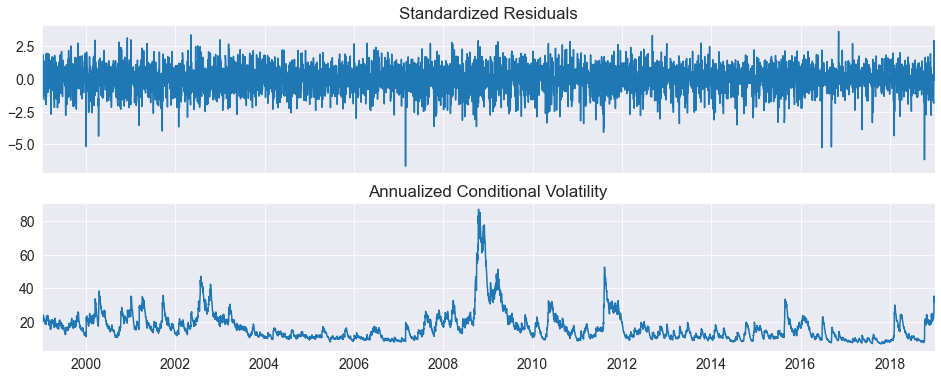

In [75]:
# Specify GARCH model assumptions
basic_gm = arch_model(returns, p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot(annualize='D')
plt.show()

###  Distribution assumptions
Distribution can be changed from the default normal using the distribution property of a mean mode

#### Plot distribution of standardized residuals

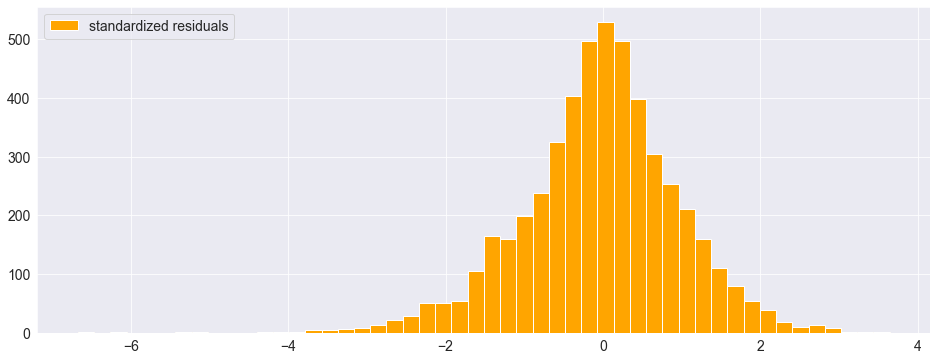

In [76]:
## Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'standardized residuals')
#plt.hist(normal_resid, bins = 50, 
        # facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

### Student’s T distribution
Financial returns are often heavy tailed, and a Student’s T distribution is a simple method to capture this feature. 

Iteration:      5,   Func. Count:     45,   Neg. LLF: 6853.865862048829
Iteration:     10,   Func. Count:     84,   Neg. LLF: 6835.516174829389
Iteration:     15,   Func. Count:    119,   Neg. LLF: 6834.735607475138
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6834.73558492444
            Iterations: 16
            Function evaluations: 126
            Gradient evaluations: 16


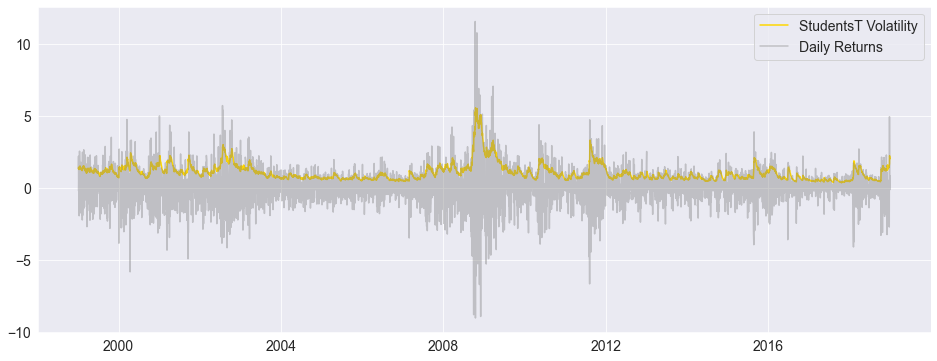

In [80]:
# Specify GARCH model assumptions
studT_gm = arch_model(returns, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'StudentsT')
# Fit the model
studT_result = studT_gm.fit(update_freq=5)

# Get model estimated volatility
studT_vol = studT_result.conditional_volatility

# Plot model fitting results
plt.plot(studT_vol, color = 'gold', label = 'StudentsT Volatility')
#plt.plot(normal_vol, color = 'red', label = 'Normal Volatility')
plt.plot(returns, color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

### Skewed t-distribution

Iteration:      5,   Func. Count:     50,   Neg. LLF: 6846.9639114185
Iteration:     10,   Func. Count:     94,   Neg. LLF: 6826.71455168787
Iteration:     15,   Func. Count:    137,   Neg. LLF: 6825.778208961764
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6825.778185697929
            Iterations: 16
            Function evaluations: 145
            Gradient evaluations: 16


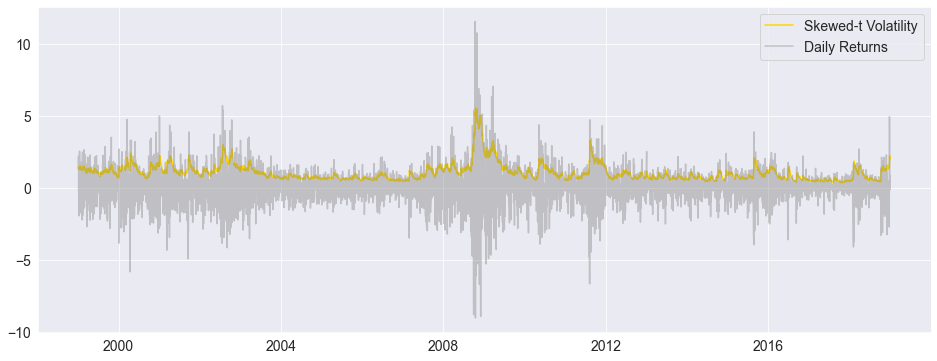

In [81]:
# Specify GARCH model assumptions
skewt_gm = arch_model(returns, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit(update_freq=5)

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(skewt_vol, color = 'gold', label = 'Skewed-t Volatility')
#plt.plot(normal_vol, color = 'red', label = 'Normal Volatility')
plt.plot(returns, color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

## Compare mean model with AR

In [83]:
cmean=arch_model(returns, p = 1, q = 1,mean = 'constant', vol = 'GARCH')
cmean_result=cmean.fit()
# Print model summary of GARCH with constant mean
print(cmean_result.summary())
# Print model summary of GARCH with AR mean
armean=arch_model(returns, p = 1, q = 1, mean = 'AR', lags = 1, vol = 'GARCH')
armean_result=armean.fit()
print(armean_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6955.831420300672
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6951.317990771391
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6947.064646379318
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6946.364782136111
Iteration:      5,   Func. Count:     39,   Neg. LLF: 6942.15956734673
Iteration:      6,   Func. Count:     46,   Neg. LLF: 6939.773482620687
Iteration:      7,   Func. Count:     53,   Neg. LLF: 6938.412985853714
Iteration:      8,   Func. Count:     60,   Neg. LLF: 6936.760062473037
Iteration:      9,   Func. Count:     66,   Neg. LLF: 6936.742015555643
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6936.71853003242
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6936.718477489705
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6936.718476989003
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11


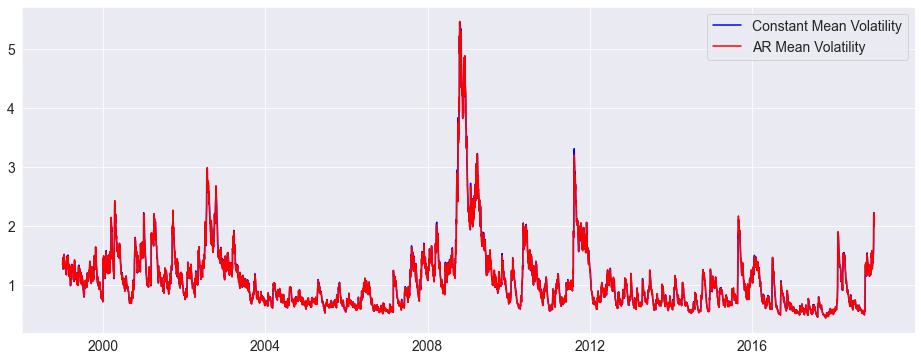

In [84]:
# Get model estimated volatility
cmean_vol = cmean_result.conditional_volatility
armean_vol=armean_result.conditional_volatility

# Plot model volatility 
plt.plot(cmean_vol, color = 'blue', label = 'Constant Mean Volatility')
plt.plot(armean_vol, color = 'red', label = 'AR Mean Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [86]:
# Check correlation of volatility estimations
#print(np.corrcoef(cmean_vol, armean_vol)[0,1])

### GJR-GARCH
Additional inputs can be used to construct other models. This example sets o to 1

In [87]:
# Specify model assumptions
gjr_gm = arch_model(returns, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(update_freq=5,disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6744.43
Distribution:      Standardized Student's t   AIC:                           13500.9
Method:                  Maximum Likelihood   BIC:                           13540.0
                                              No. Observations:                 5030
Date:                      Sun, Sep 13 2020   Df Residuals:                     5024
Time:                              14:59:06   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

### EGARCH

In [88]:
# Specify model assumptions
egarch_gm = arch_model(returns, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(update_freq=5,disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -6729.21
Distribution:      Standardized Student's t   AIC:                           13470.4
Method:                  Maximum Likelihood   BIC:                           13509.6
                                              No. Observations:                 5030
Date:                      Sun, Sep 13 2020   Df Residuals:                     5024
Time:                              14:59:07   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

### TARCH/ZARCH
TARCH (also known as ZARCH) model the volatility using absolute values. This model is specified using power=1.0 since the default power, 2, corresponds to variance processes that evolve in squares.

In [89]:
# Specify model assumptions
zgarch_gm = arch_model(returns, p = 1, q = 1, o = 1, power=1.0)

# Fit the model
zgarch_result = zgarch_gm.fit(update_freq=5)

# Print model fitting summary
print(zgarch_result.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 6807.734808859357
Iteration:     10,   Func. Count:     88,   Neg. LLF: 6799.179902576483
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6799.17852245191
            Iterations: 14
            Function evaluations: 116
            Gradient evaluations: 13
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -6799.18
Distribution:                  Normal   AIC:                           13608.4
Method:            Maximum Likelihood   BIC:                           13641.0
                                        No. Observations:                 5030
Date:                Sun, Sep 13 2020   Df Residuals:                     5025
Time:         

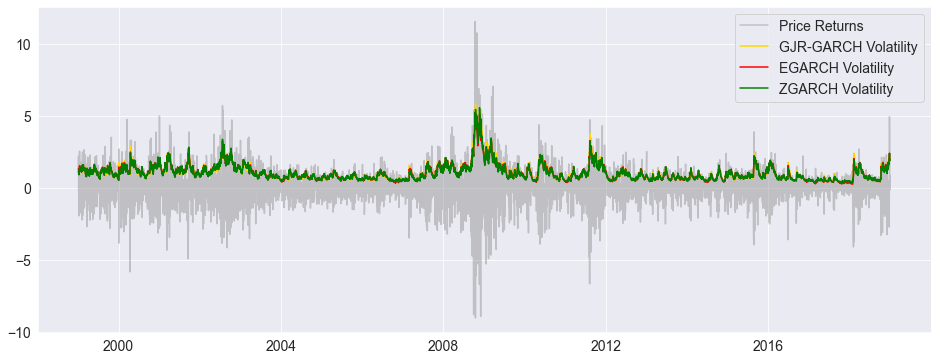

In [90]:
# Get model estimated volatility
gjrgm_vol= gjrgm_result.conditional_volatility
egarch_vol=egarch_result.conditional_volatility
zgarch_vol=zgarch_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(returns, color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

# Plot ZGARCH  estimated volatility
plt.plot(zgarch_vol, color = 'green', label = 'ZGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

# Make forecast with GARCH models

## Basic Forecasting

In [126]:
forecasts = gm_result.forecast()
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2018-12-27  0.056843
2018-12-28  0.056843
2018-12-31  0.056843
                 h.1
Date                
2018-12-27  4.434250
2018-12-28  3.946822
2018-12-31  3.575621
                 h.1
Date                
2018-12-27  4.434250
2018-12-28  3.946822
2018-12-31  3.575621


## Fixed Window Forecasting

In [91]:

# Make 3-period ahead forecast
gm_result = basic_gm.fit(last_obs='2018-12-1',update_freq = 5)
gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.mean.iloc[-3:])
print(gm_forecast.residual_variance.iloc[-3:])
# Print the forecast variance
print(gm_forecast.variance.iloc[-3:])


Iteration:      5,   Func. Count:     39,   Neg. LLF: 6899.840161686376
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6894.816543133209
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6894.8164793992855
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 11
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2018-12-27  0.056843  0.056843  0.056843  0.056843  0.056843
2018-12-28  0.056843  0.056843  0.056843  0.056843  0.056843
2018-12-31  0.056843  0.056843  0.056843  0.056843  0.056843
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2018-12-27  4.434250  4.393097  4.352491  4.312422  4.272885
2018-12-28  3.946822  3.912132  3.877901  3.844124  3.810795
2018-12-31  3.575621  3.545851  3.516476  3.487491  3.458889
                 h.1       h.2     

Values that are not computed are nan-filled

## GARCH rolling window forecast

In [123]:
start_loc = 0
end_loc = np.where(returns.index >= '2018-11-15')[0].min()
forecasts = {}
for i in range(30):
    #sys.stdout.write('.')
    #sys.stdout.flush()
    res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast    
    # Save all forecast to a DataFrame
    forecast_var = pd.DataFrame(forecasts).T
print()
print(pd.DataFrame(forecasts).T)


                 h.1
2018-11-14  1.493624
2018-11-15  1.441553
2018-11-16  1.296224
2018-11-19  1.466226
2018-11-20  1.671645
2018-11-21  1.502742
2018-11-23  1.399227
2018-11-26  1.483766
2018-11-27  1.338076
2018-11-28  1.714849
2018-11-29  1.542284
2018-11-30  1.440915
2018-12-03  1.402436
2018-12-04  2.365358
2018-12-06  2.113977
2018-12-07  2.471357
2018-12-10  2.205022
2018-12-11  1.970086
2018-12-12  1.785152
2018-12-13  1.597917
2018-12-14  1.824316
2018-12-17  2.095187
2018-12-18  1.872497
2018-12-19  1.933656
2018-12-20  2.000148
2018-12-21  2.244000
2018-12-24  2.786281
2018-12-26  4.976057
2018-12-27  4.478506
2018-12-28  3.977940


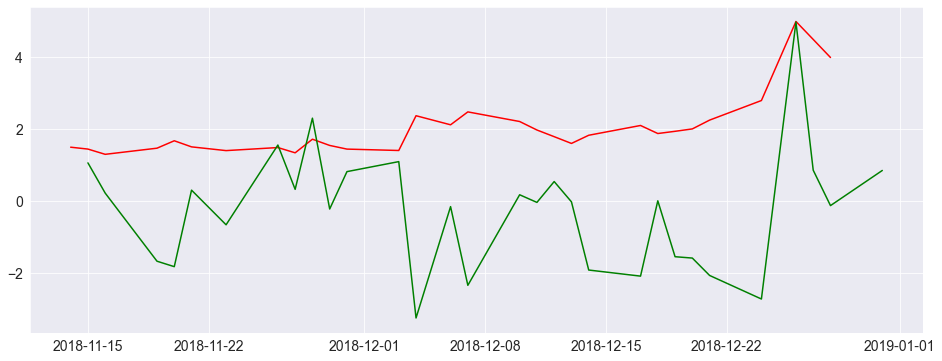

In [125]:
# Plot the forecast variance
plt.plot(forecast_var, color = 'red')
plt.plot(returns['2018-11-15':'2018-12-31'], color = 'green')
plt.show()

## Recursive Forecast Generation
Recursive is similar to rolling except that the initial observation does not change. This can be easily implemented by dropping the first_obs input.

In [118]:
start_loc = 0
end_loc = np.where(returns.index >= '2018-11-15')[0].min()
forecasts = {}
for i in range(30):
    res = basic_gm.fit(last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)


                 h.1       h.2       h.3
2018-11-14  1.493624  1.491442  1.489289
2018-11-15  1.441654  1.440148  1.438662
2018-11-16  1.295886  1.296281  1.296671
2018-11-19  1.466241  1.464418  1.462619
2018-11-20  1.671971  1.667494  1.663077
2018-11-21  1.503370  1.501073  1.498805
2018-11-23  1.399533  1.398581  1.397642
2018-11-26  1.484299  1.482251  1.480230
2018-11-27  1.338529  1.338373  1.338220
2018-11-28  1.713387  1.708404  1.703488
2018-11-29  1.541675  1.538904  1.536169
2018-11-30  1.440878  1.439408  1.437958
2018-12-03  1.402254  1.401285  1.400329
2018-12-04  2.362517  2.349408  2.336469
2018-12-06  2.112619  2.102673  2.092857
2018-12-07  2.469232  2.454808  2.440569
2018-12-10  2.204180  2.193102  2.182167
2018-12-11  1.969635  1.961519  1.953509
2018-12-12  1.785454  1.779673  1.773968
2018-12-13  1.599084  1.595675  1.592311
2018-12-14  1.825131  1.818859  1.812670
2018-12-17  2.095597  2.085925  2.076378
2018-12-18  1.873333  1.866468  1.859691
2018-12-19  1.9

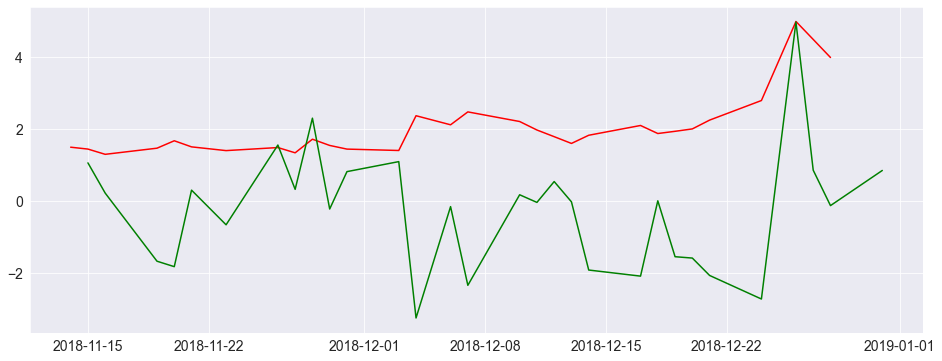

In [119]:
# Plot the forecast variance
plt.plot(forecast_var, color = 'red')
plt.plot(returns['2018-11-15':'2018-12-31'], color = 'green')
plt.show()

## TARCH Forecasts
### Simulation Forecasts: Add an additional attribute of an ARCHModelForecast object: simulation.

(736332.0, 736692.0)

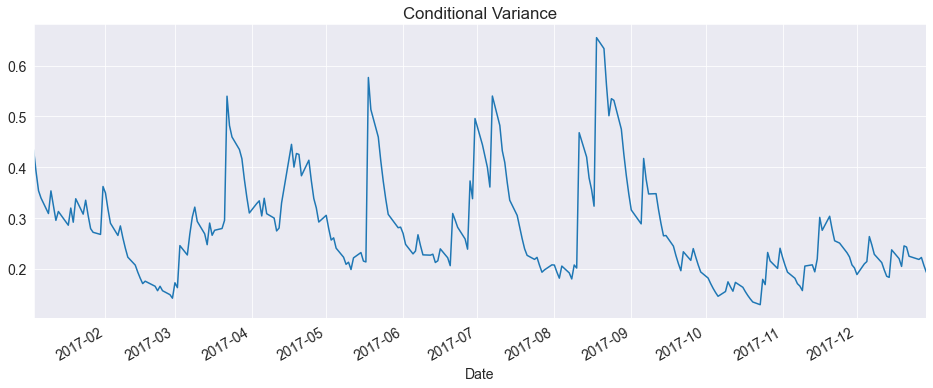

In [131]:
fig, ax = plt.subplots(1, 1)
var_2017 = zgarch_result.conditional_volatility['2017']**2.0
subplot = var_2017.plot(ax=ax, title='Conditional Variance')
subplot.set_xlim(var_2017.index[0], var_2017.index[-1])

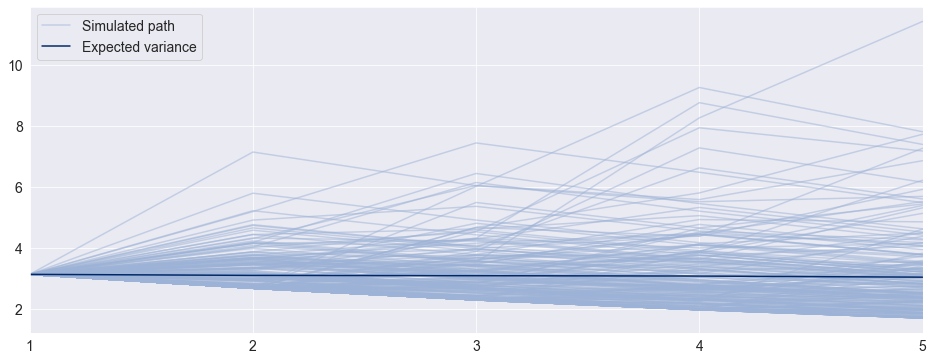

In [132]:
forecasts = zgarch_result.forecast(horizon=5, method='simulation')
sims = forecasts.simulations

x = np.arange(1, 6)
lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated path')
line = plt.plot(x, forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
plt.gca().set_xticks(x)
plt.gca().set_xlim(1,5)
legend = plt.legend()

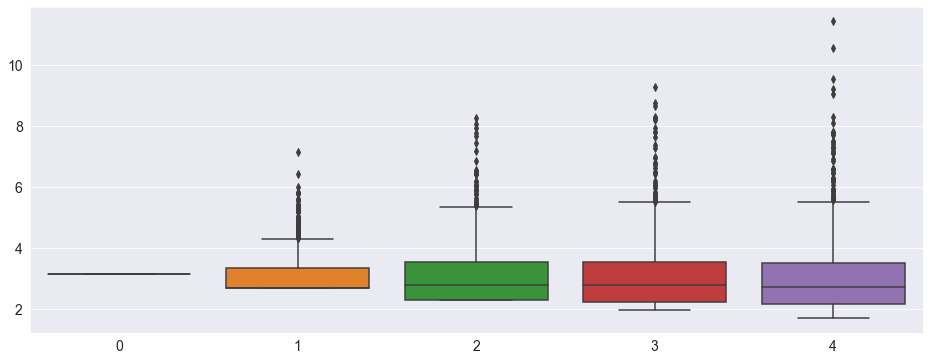

In [133]:
import seaborn as sns
sns.boxplot(data=sims.variances[-1])

## TARCH Forecasts
### Bootstrap Forecasts: Add an additional attribute of an ARCHModelForecast object: Bootstrap

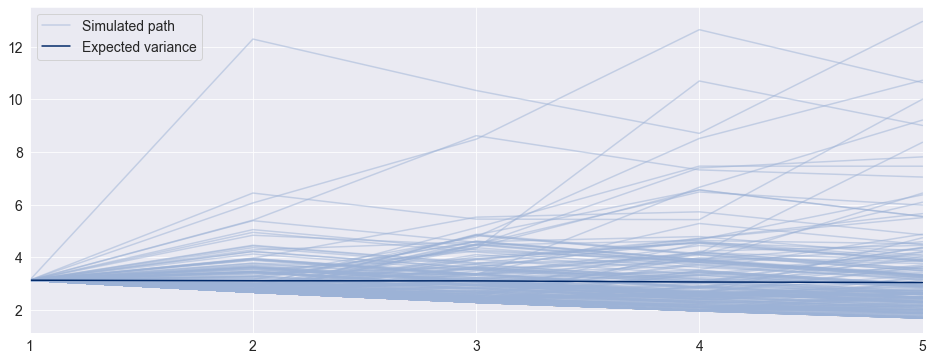

In [134]:
forecasts = zgarch_result.forecast(horizon=5, method='bootstrap')
sims = forecasts.simulations

x = np.arange(1, 6)
lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated path')
line = plt.plot(x, forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
plt.gca().set_xticks(x)
plt.gca().set_xlim(1,5)
legend = plt.legend()

## Value-at-Risk Forecasting

In [147]:
# Specify GARCH model assumptions
skewt_gm = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='skewt')
# Fit the model
skewt_result = skewt_gm.fit(disp='off', last_obs='2017-12-31')

#### Estimate the VaR
The quantiles can be computed using the ppf method of the distribution attached to the model. 

In [148]:
forecasts = skewt_result.forecast(start='2018-1-1')
cond_mean = forecasts.mean['2018':]
cond_var = forecasts.variance['2018':]
q = skewt_gm.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484848 -1.64965964]


#### Plot the two VaRs along with the returns.

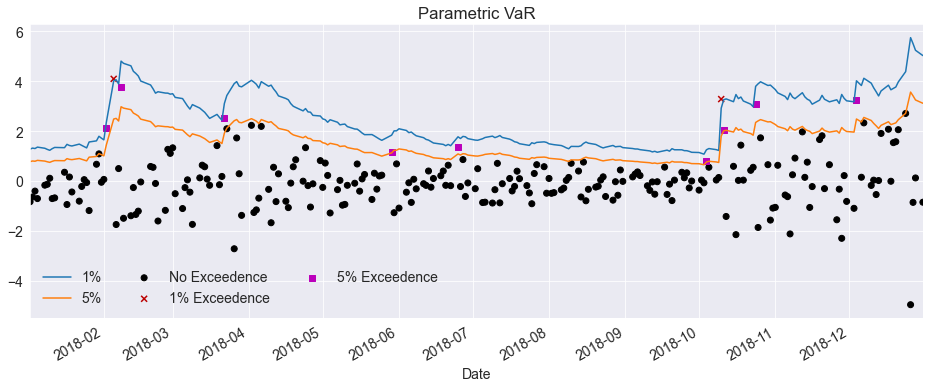

In [149]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns['2018':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)

#### Filtered Historical Simulation
Use the empirical distribution of the standardized residuals to estimate the quantiles.


In [150]:
std_rets = (returns[:'2017'] - skewt_result.params['mu']) / skewt_result.conditional_volatility
std_rets = std_rets.dropna()
q = std_rets.quantile([.01, .05])
print(q)

0.01   -2.668273
0.05   -1.723353
dtype: float64


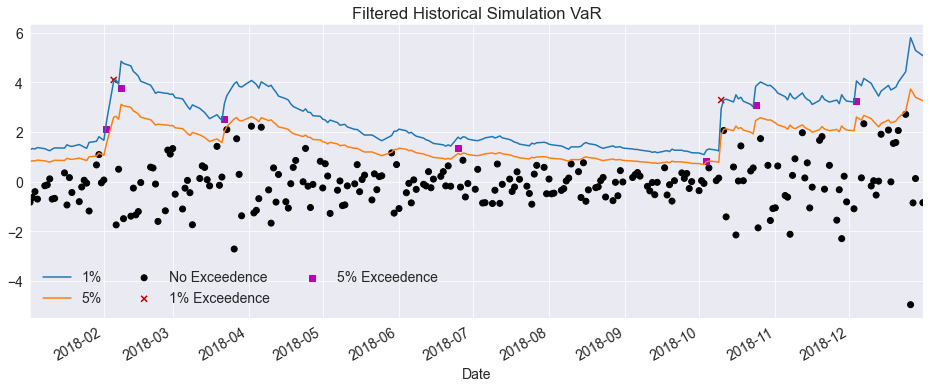

In [151]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns['2018':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Filtered Historical Simulation VaR')
leg = ax.legend(frameon=False, ncol=3)

# Model parameters

In [152]:
# Print model fitting summary
print(gm_result.summary())

# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6894.82
Distribution:                  Normal   AIC:                           13797.6
Method:            Maximum Likelihood   BIC:                           13823.7
                                        No. Observations:                 5011
Date:                Sun, Sep 13 2020   Df Residuals:                     5007
Time:                        14:59:21   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0568  1.148e-02      4.953  7.296e-07 [3.

In [153]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-value by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print calculated t-statistic
print(calculated_t)

# Print parameter stats
print(para_summary)

mu           4.953321
omega        3.762276
alpha[1]     7.821704
beta[1]     64.090196
dtype: float64
          parameter   std-err    t-value
mu         0.056843  0.011476   4.953321
omega      0.017632  0.004687   3.762276
alpha[1]   0.101392  0.012963   7.821704
beta[1]    0.885351  0.013814  64.090196


### ACF plot

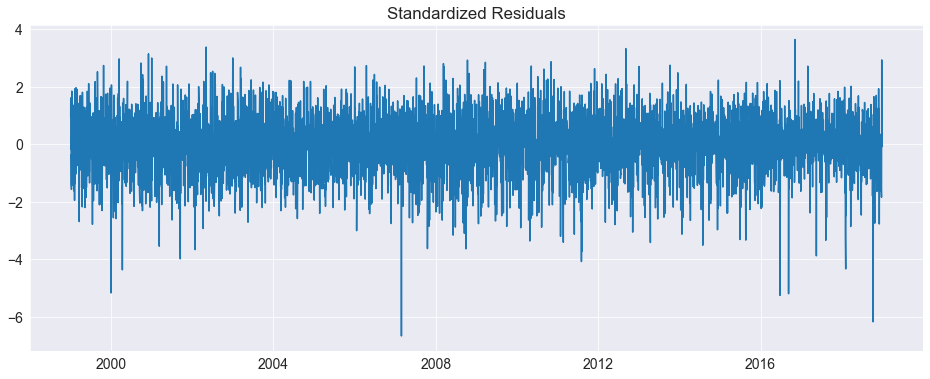

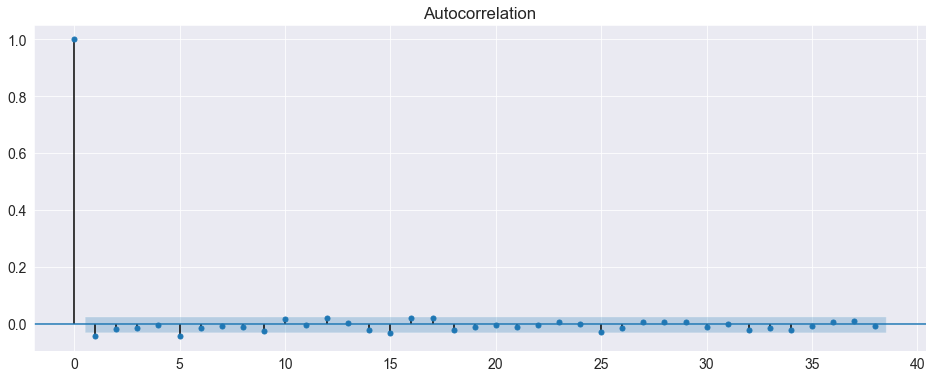

In [154]:
# Import the Python module
from statsmodels.graphics.tsaplots import plot_acf

# Plot the standardized residuals
plt.plot(gm_std_resid)
plt.title('Standardized Residuals')
plt.show()

# Generate ACF plot of the standardized residuals
plot_acf(gm_std_resid, alpha = 0.05)
plt.show()

In [156]:
# Print normal GARCH model summary
print(gm_result.summary())
# Print skewed GARCH model summary
print(skewt_result.summary())

# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6894.82
Distribution:                  Normal   AIC:                           13797.6
Method:            Maximum Likelihood   BIC:                           13823.7
                                        No. Observations:                 5011
Date:                Sun, Sep 13 2020   Df Residuals:                     5007
Time:                        14:59:21   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0568  1.148e-02      4.953  7.296e-07 [3.

### AIC and BIC

In [157]:
# Print the AIC GJR-GARCH
print('AIC of GJR-GARCH model :', gjrgm_result.aic)
# Print the AIC of EGARCH
print('AIC of EGARCH model :', egarch_result.aic)
# Print the AIC of EGARCH
print('AIC of ZGARCH model :', zgarch_result.aic)

# Print the BIC GJR-GARCH
print('BIC of GJR-GARCH model :', gjrgm_result.bic)
# Print the BIC of EGARCH
print('BIC of EGARCH model :', egarch_result.bic)
# Print the BIC of ZGARCH
print('BIC of ZGARCH model :', zgarch_result.bic)

AIC of GJR-GARCH model : 13500.862776482367
AIC of EGARCH model : 13470.426104680793
AIC of ZGARCH model : 13608.35704490382
BIC of GJR-GARCH model : 13540.00182806093
BIC of EGARCH model : 13509.565156259356
BIC of ZGARCH model : 13640.972921219289


### MAE, MSE

In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse



In [159]:
forecast_var['return']=sp_price['Return']
# Backtest model with MAE, MSE
evaluate(forecast_var['return'], forecast_var['h.1'])

Mean Absolute Error (MAE): 2.4
Mean Squared Error (MSE): 8.31


(2.3953959345014284, 8.306351400698151)